In [3]:
from rdkit import Chem
patt_sel = Chem.MolFromSmarts("*!:ccc(!:*)ccc")
patt_not1 = Chem.MolFromSmarts("*!:cc(!:*)cccc")
patt_not2 = Chem.MolFromSmarts("*!:cccc(!:*)cc")
patt_not3 = Chem.MolFromSmarts("*!:ccc(!:*)cc(!:*)c")

ligand_r6 = []
with open("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/lig_in_pdb/pdb_dataset/Components-smiles-stereo-oe.smi") as inputfile:
    for line in inputfile:
        try:
            mol = Chem.MolFromSmiles(line.split()[0])
            if mol.GetSubstructMatches(patt_sel) and not mol.GetSubstructMatches(patt_not1) and not mol.GetSubstructMatches(patt_not2) and not mol.GetSubstructMatches(patt_not3):
                ligand_r6.append(line)
        except:
            pass


[10:30:53] SMILES Parse Error: syntax error while parsing: 01S
[10:30:53] SMILES Parse Error: Failed parsing SMILES '01S' for input: '01S'
[10:30:53] Explicit valence for atom # 21 N, 4, is greater than permitted
[10:30:53] Explicit valence for atom # 0 Be, 4, is greater than permitted
[10:30:53] SMILES Parse Error: syntax error while parsing: 0D3
[10:30:53] SMILES Parse Error: Failed parsing SMILES '0D3' for input: '0D3'
[10:30:53] SMILES Parse Error: syntax error while parsing: 0DB
[10:30:53] SMILES Parse Error: Failed parsing SMILES '0DB' for input: '0DB'
[10:30:53] SMILES Parse Error: syntax error while parsing: 0DY
[10:30:53] SMILES Parse Error: Failed parsing SMILES '0DY' for input: '0DY'
[10:30:53] SMILES Parse Error: syntax error while parsing: 0E9
[10:30:53] SMILES Parse Error: Failed parsing SMILES '0E9' for input: '0E9'
[10:30:53] SMILES Parse Error: syntax error while parsing: 0ED
[10:30:53] SMILES Parse Error: Failed parsing SMILES '0ED' for input: '0ED'
[10:30:53] SMILES 

In [4]:
print(len(ligand_r6))

1695


In [5]:
with open("lig_menu/AaaaA_only2.csv","w") as output:
    for line in ligand_r6:
        output.write(line)

In [14]:
from rdkit.Chem.Draw import IPythonConsole
# 显示图片

In [264]:
with open("lig_AaaaA_test3.csv",'w') as output:
    for item in ligand_r6:
        output.write(item)


In [226]:
#函数一，获取marker邻居原子的index, 注意marker只能是一个单键连接核上的原子，否则邻居会多于一个
def get_neiid_bysymbol(mol,marker):
    try:
        for atom in mol.GetAtoms():
            if atom.GetSymbol()==marker:
                neighbors=atom.GetNeighbors()
                if len(neighbors)>1:
                    print ('Cannot process more than one neighbor, will only return one of them')
                atom_nb=neighbors[0]
                return atom_nb.GetIdx()
    except Exception as e:
        print (e)
        return None
#函数二，获取marker原子的index
def get_id_bysymbol(mol,marker):
    for atom in mol.GetAtoms():
        if atom.GetSymbol()==marker:
            return atom.GetIdx()

In [227]:
def combine2frags(mol_a,mol_b,maker_b='Cs',maker_a='Fr'):
    #将两个待连接分子置于同一个对象中
    merged_mol = Chem.CombineMols(mol_a,mol_b)
    bind_pos_a=get_neiid_bysymbol(merged_mol,maker_a)
    bind_pos_b=get_neiid_bysymbol(merged_mol,maker_b)
    #转换成可编辑分子，在两个待连接位点之间加入单键连接，特殊情形需要其他键类型的情况较少，需要时再修改
    ed_merged_mol= Chem.EditableMol(merged_mol)
    ed_merged_mol.AddBond(bind_pos_a,bind_pos_b,order=Chem.rdchem.BondType.SINGLE)
    #将图中多余的marker原子逐个移除，先移除marker a
    marker_a_idx=get_id_bysymbol(merged_mol,maker_a)
    ed_merged_mol.RemoveAtom(marker_a_idx)
    #marker a移除后原子序号变化了，所以又转换为普通分子后再次编辑，移除marker b
    temp_mol = ed_merged_mol.GetMol()
    marker_b_idx=get_id_bysymbol(temp_mol,maker_b)
    ed_merged_mol=Chem.EditableMol(temp_mol)
    ed_merged_mol.RemoveAtom(marker_b_idx)
    final_mol = ed_merged_mol.GetMol()
    return final_mol

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem,Draw

# 读入分子
mol = Chem.MolFromSmiles("CC(C)(C)c1cc(n(n1)c2cccc(c2)N)NC(=O)Nc3ccccc3")
# 识别间位取代部分
patt = Chem.MolFromSmarts("*!:ccc(!:*)ccc")
match = mol.GetSubstructMatches(patt)

# 识别替换苯环原子
ri = mol.GetRingInfo()
for r in ri.AtomRings():
    count = 0
    for item in match[0]:
        if item in set(r):
            count+=1
    if count == 6:
        phenyl_num = set(r)

# 识别两个间位取代基与苯环的连接原子
connect_atoms = list(set(match[0])-phenyl_num)

# 识别所有的成键信息
bond_num = mol.GetNumBonds()
nei_bond = []
for i in range(bond_num):
    nei_bond.append((mol.GetBondWithIdx(i).GetBondType().name,mol.GetBondWithIdx(i).GetBeginAtomIdx(),mol.GetBondWithIdx(i).GetEndAtomIdx()))
# 记录第一部分的原子数目
mol1_Atom_num = mol.GetNumAtoms()

# 引入螺旋桨烷，并将其与原分子置于一处，使得其编号从·mol1_Atom_num+0·开始
re_pat = Chem.MolFromSmiles("C12CCCC(C2)C1")
mid_mol = Chem.CombineMols(mol,re_pat)

# 开始成键
mid_edited = Chem.EditableMol(mid_mol)
# 螺旋桨烷烃的桥头碳分别为mol1_Atom_num和mol1_Atom_num+4
mid_edited.AddBond(connect_atoms[0],mol1_Atom_num,order=Chem.rdchem.BondType.SINGLE)
mid_edited.AddBond(connect_atoms[1],mol1_Atom_num+4,order=Chem.rdchem.BondType.SINGLE)
# 删除原来的苯环
for i in range(6):
    mid_edited.RemoveAtom(min(phenyl_num))
BCHep_mol = mid_edited.GetMol()

old_new = {}
for item in range(mol1_Atom_num-6):
    if item < min(phenyl_num):
        old_new[item] = item
    else:
        old_new[item+6] = item 

BCHep_mol


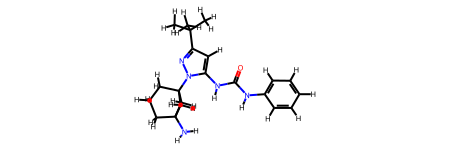

In [4]:
BCHep_mol
smi=Chem.MolToSmiles(BCHep_mol)
mol = Chem.MolFromSmiles(smi)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
mol


In [29]:
from rdkit.Chem import rdFMCS

#     mcs = rdFMCS.FindMCS([refmol, inpmol],timeout=3, completeRingsOnly=True)
structure_from_pdb = Chem.MolFromPDBFile("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/lig_in_pdb/test/1AW.pdb")
structure_from_pdb = Chem.RemoveAllHs(structure_from_pdb)
mol_tem = Chem.MolFromSmiles("CC(C)(C)c1cc(n(n1)c2cccc(c2)N)NC(=O)Nc3ccccc3")
structure_refine = AllChem.AssignBondOrdersFromTemplate(mol_tem,structure_from_pdb)
refmol = structure_refine
inpmol = mol
mcs = rdFMCS.FindMCS([refmol, inpmol],timeout=3,matchValences=True,ringMatchesRingOnly=True,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
mcs.smartsString

[22:06:07] WARNING: More than one matching pattern found - picking one



'[#6&R]1:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1)-&!@[#7&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#7&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R](:&@[#7&R]:&@[#7&R]:&@1-&!@[#6&R])-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&!@[#6&!R]'

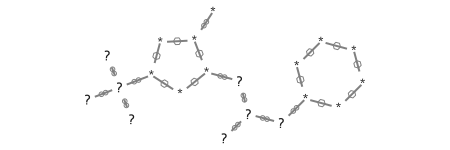

In [30]:
bonded_conf = refmol.GetConformer()
conf_res = inpmol.GetConformer()
inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol)
ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol,inpmol_prop)

conf_res
mcs.queryMol

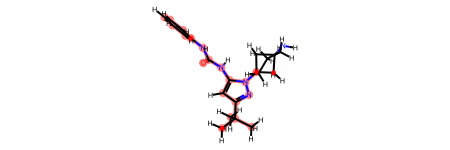

In [31]:
for i, j in zip(refmol.GetSubstructMatch(mcs.queryMol), inpmol.GetSubstructMatch(mcs.queryMol)):
    ff_mcs.AddFixedPoint(j)
    conf_res.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))
try:
    ff_mcs.Minimize()
except:
    pass
inpmol

In [414]:
re_pat = Chem.MolFromSmiles("C12CCCC(C2)C1")
re_pat = Chem.AddHs(re_pat)
AllChem.EmbedMolecule(re_pat)
Chem.MolToPDBFile(re_pat,"es.pdb")

In [35]:
from rdkit import Chem
def phe2bch_with_smiles(smi):
    # 读入分子
    mol = Chem.MolFromSmiles(smi)
    # 识别间位取代部分
    patt = Chem.MolFromSmarts("*!:ccc(!:*)ccc")
    match = mol.GetSubstructMatches(patt)
    # 识别替换苯环原子
    ri = mol.GetRingInfo()
    for r in ri.AtomRings():
        count = 0
        for item in match[0]:
            if item in set(r):
                count+=1
        if count == len(match[0])-2:
            phenyl_num = set(r)
    # 识别两个间位取代基与苯环的连接原子
    connect_atoms = list(set(match[0])-phenyl_num)
    phenyl_atoms = list(phenyl_num)
    phenyl_atoms.sort(reverse=True)
    # 记录第一部分的原子数目
    mol1_Atom_num = mol.GetNumAtoms()
    # 引入螺旋桨烷，并将其与原分子置于一处，使得其编号从·mol1_Atom_num+0·开始
    re_pat = Chem.MolFromSmiles("C12CCCC(C2)C1")
    mid_mol = Chem.CombineMols(mol,re_pat)
    # 开始成键
    mid_edited = Chem.EditableMol(mid_mol)
    # 螺旋桨烷烃的桥头碳分别为mol1_Atom_num和mol1_Atom_num+4
    mid_edited.AddBond(connect_atoms[0],mol1_Atom_num,order=Chem.rdchem.BondType.SINGLE)
    mid_edited.AddBond(connect_atoms[1],mol1_Atom_num+4,order=Chem.rdchem.BondType.SINGLE)
    # 删除原来的苯环
    for i in phenyl_atoms:
        mid_edited.RemoveAtom(i)
    BCHep_mol = mid_edited.GetMol()
    return BCHep_mol  


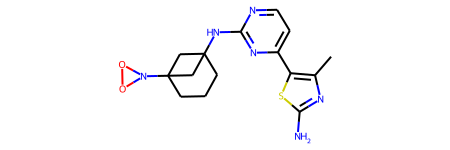

In [36]:
from rdkit.Chem import AllChem,Draw
test = phe2bch_with_smiles("Cc1c(sc(n1)N)c2ccnc(n2)Nc3cccc(c3)n4oo4")
test

In [47]:
def getpdb(refmol,inpmol,pdbfile):
    mcs = rdFMCS.FindMCS([refmol, inpmol],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
    bonded_conf = refmol.GetConformer()
    conf_res = inpmol.GetConformer()
    inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol)
    ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol,inpmol_prop)
    for i, j in zip(refmol.GetSubstructMatch(mcs.queryMol), inpmol.GetSubstructMatch(mcs.queryMol)):
        ff_mcs.AddFixedPoint(j)
        conf_res.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))
    try:
        ff_mcs.Minimize()
    except:
        pass
    Chem.MolToPDBFile(inpmol, pdbfile)
    return inpmol

def phe2bch_topdb(smi0,refpdb,name):
    mol = phe2bch_with_smiles(smi0)
    smi = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    mol = Chem.RemoveAllHs(mol)

    structure_from_pdb = Chem.MolFromPDBBlock(refpdb)
    structure_from_pdb = Chem.RemoveAllHs(structure_from_pdb)
    mol_tem = Chem.MolFromSmiles(smi0)
    structure_refine = AllChem.AssignBondOrdersFromTemplate(mol_tem,structure_from_pdb)
    getpdb(structure_refine,mol,f"{name}")

In [37]:
def pdb_2_lig_block(pdb_path,lig_id):
    ligand_lines = []
    with open(pdb_path) as ent:
        for line in ent:
            if line[0:6] == "HETATM" and line[17:20] == lig_id:
                ligand_lines.append(line)
    ligand_num = len(ligand_lines)
    for i in range(1,len(ligand_lines)):
        if ligand_lines[i][17:26] != ligand_lines[i-1][17:26]:
            ligand_num = i
            break
        else:
            pass
    lig_Block="".join(ligand_lines[0:ligand_num])
    return lig_Block




In [38]:
test = pdb_2_lig_block("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/lig_in_pdb/pdb_dataset/pdb/pdb2x4f.ent","16X")
test

'HETATM 4571  N7A 16X A1374      87.045  49.887  34.701  1.00 74.94           N  \nHETATM 4572  C3A 16X A1374      87.021  49.729  33.388  1.00 76.59           C  \nHETATM 4573  N2A 16X A1374      86.404  48.739  32.742  1.00 73.60           N  \nHETATM 4574  C1A 16X A1374      86.503  48.771  31.404  1.00 73.21           C  \nHETATM 4575  C6A 16X A1374      85.963  47.868  30.506  1.00 70.70           C  \nHETATM 4576  S4A 16X A1374      87.751  50.748  32.313  1.00 75.54           S  \nHETATM 4577  C5A 16X A1374      87.258  49.877  30.962  1.00 76.47           C  \nHETATM 4578  C4  16X A1374      87.600  50.266  29.659  1.00 75.82           C  \nHETATM 4579  N3  16X A1374      88.407  51.330  29.510  1.00 77.28           N  \nHETATM 4580  C5  16X A1374      87.153  49.606  28.517  1.00 74.96           C  \nHETATM 4581  C6  16X A1374      87.554  50.073  27.278  1.00 75.22           C  \nHETATM 4582  N1  16X A1374      88.344  51.123  27.200  1.00 76.62           N  \nHETATM 4583  C2